**Description:** The project focuses on developing and evaluating dynamic pricing models for retail. It compares traditional statistical methods like ARIMA with ensemble learning techniques, such as Random Forests. 

**Research Problem:** Traditional models often struggle with complex data patterns and large datasets. The problem is to determine whether advanced ensemble learning techniques can outperform traditional time-series models in predicting optimal prices.

### Strategies for Dynamic Pricing:
1. **Rule-Based Pricing:** Setting prices based on predefined rules like competitor prices, stock levels, or markdown schedules. Works well as a baseline for both model types.
2. **Demand Forecasting:** Predicting future demand to adjust prices dynamically, commonly used in time-series models.
3. **Elasticity-Based Pricing:** Adjusting prices based on the estimated price elasticity of demand, often implemented using ensemble models for non-linear relationships.
4. **Optimization-Based Pricing:** Using optimization algorithms to maximize revenue or profit by integrating model predictions with constraints like inventory and competitor prices.
5. **Context-Aware Pricing:** Leveraging additional factors like seasonality, promotions, or customer behavior, often better captured by ensemble models due to their feature flexibility.

### Differences in Strategies:
1. **Time-Series Models:** Focus on temporal patterns and demand forecasting, relying heavily on historical sales and seasonality trends.
2. **Ensemble Models:** Incorporate broader feature sets (e.g., competitor prices, customer ratings) and excel in capturing complex, non-linear relationships, making them suitable for context-aware and elasticity-based pricing.

### Data Understanding
This dataset provides synthetic yet realistic data for analyzing and forecasting retail store inventory demand. It contains over 73000 rows of daily data across multiple stores and products, including attributes like sales, inventory levels, pricing, weather, promotions, and holidays.

1. Date: Daily records from [start_date] to [end_date].
2. Store ID & Product ID: Unique identifiers for stores and products.
3. Category: Product categories like Electronics, Clothing, Groceries, etc.
4. Region: Geographic region of the store.
5. Inventory Level: Stock available at the beginning of the day.
6. Units Sold: Units sold during the day.
7. Demand Forecast: Predicted demand based on past trends.
8. Weather Condition: Daily weather impacting sales.
9. Holiday/Promotion: Indicators for holidays or promotions.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [4]:
dataset = pd.read_csv("Datasets/retail_store_inventory.csv")

In [5]:
dataset.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,20,Rainy,1,79.52,Spring


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

### Exploratory Data Analysis

In [7]:
dataset.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [8]:
# Dealing with outliers
dataset.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [9]:
dataset.isna().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [10]:
dataset['Date'] = pd.to_datetime(dataset['Date'])  # Ensure 'Date' is in datetime format


In [11]:
# Adding 'Week', 'Month', and 'Year' features
dataset['Week'] = dataset['Date'].dt.isocalendar().week
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year

In [12]:
# Calculate revenue for each row
dataset['Revenue'] = dataset['Units Sold'] * dataset['Price']

In [13]:
dataset.head(2)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Week,Month,Year,Revenue
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn,52,1,2022,4254.5
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn,52,1,2022,9451.5


#### How do sales trends vary over time (weekly, monthly, yearly, seasonally)?

In [14]:
# Group by Week
weekly_sales = dataset.groupby('Week')['Units Sold'].sum().reset_index()
# Group by Month
monthly_sales = dataset.groupby('Month')['Units Sold'].sum().reset_index()
# Group by Year
yearly_sales = dataset.groupby('Year')['Units Sold'].sum().reset_index()
# Group by Seasonality
seasonal_sales = dataset.groupby('Seasonality')['Units Sold'].sum().reset_index()

# Define the groups and their respective titles and x-axis labels
groups = [('Week', weekly_sales, 'Weekly Sales Trend', 'Week'),
          ('Month', monthly_sales, 'Monthly Sales Trend', 'Month'),
          ('Year', yearly_sales, 'Yearly Sales Trend', 'Year'),
          ('Seasonality', seasonal_sales, 'Seasonal Sales Trend', 'Season')]

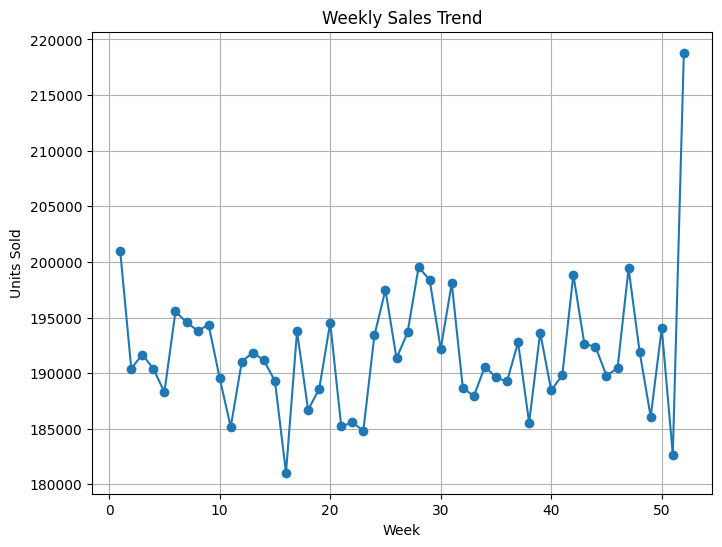

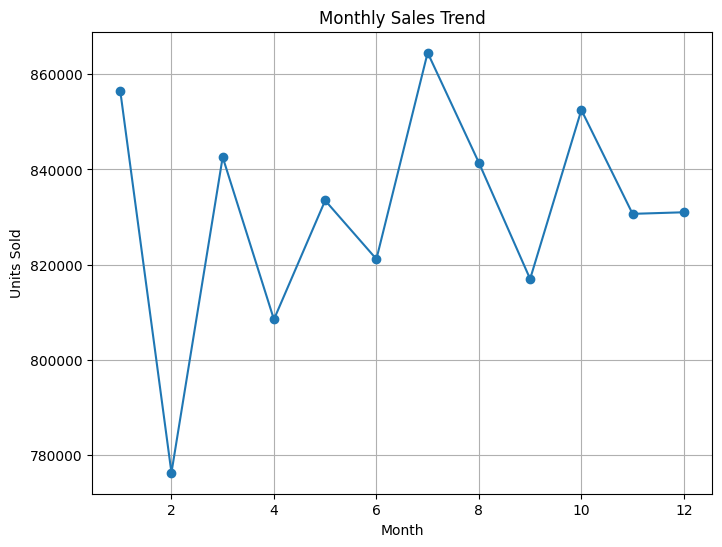

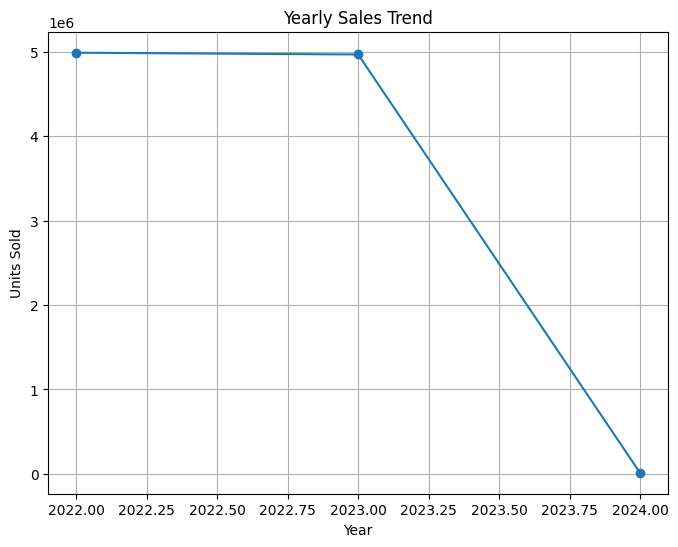

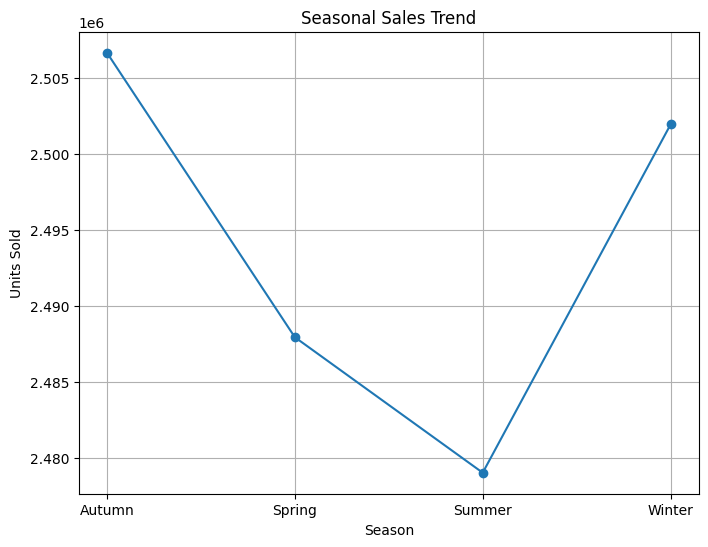

In [15]:
# Loop through each group and plot
for group, data, title, xlabel in groups:
    plt.figure(figsize=(8, 6))
    plt.plot(data[group], data['Units Sold'], marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Units Sold')
    plt.grid(True)
    plt.show()

> Weekly sales trend, shows there is an increase Units Sales during summer weeks (23-31) and during last weeks of the year (50-52)!  

> Monthly sales trend, shows there is an decrease in Units Sold after new year (in Februari) then it increases again in March and also there is an increase Units Sales during summer months (6-8)!  

> Yearly sales trend, shows linear Units Sold during 2022 and 2023 but decreases in 2024 (It maybe is due to the dataset has only data for the first month of 2024 and not the whole year)!  

> Seasonal Sales trend, starts in Autumn in the highest Units Sales, then decreases during Spring and is lowest in the Summer then increases during Winter.

#### How do revenue trends vary over time (daily, weekly, monthly, seasonally)?

In [16]:
# Group by Week
weekly_revenue = dataset.groupby('Week')['Revenue'].sum().reset_index()
# Group by Month
monthly_revenue = dataset.groupby('Month')['Revenue'].sum().reset_index()
# Group by Year
yearly_revenue = dataset.groupby('Year')['Revenue'].sum().reset_index()
# Group by Season
seasonal_revenue = dataset.groupby('Seasonality')['Revenue'].sum().reset_index()

# Define the groups and their respective titles and x-axis labels
groups = [('Week', weekly_revenue, 'Weekly Revenue Trend', 'Week'),
          ('Month', monthly_revenue, 'Monthly Revenue Trend', 'Month'),
          ('Year', yearly_revenue, 'Yearly Revenue Trend', 'Year'),
          ('Seasonality', seasonal_revenue, 'Seasonal Revenue Trend', 'Season')]

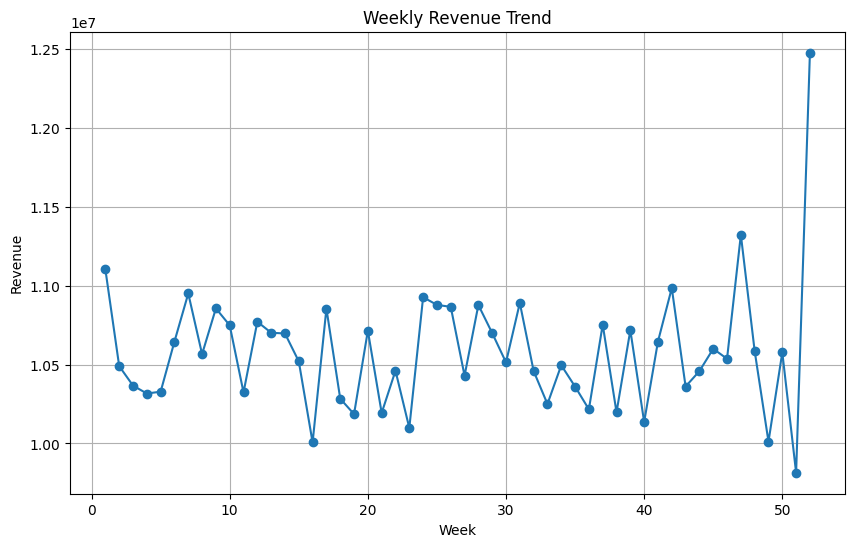

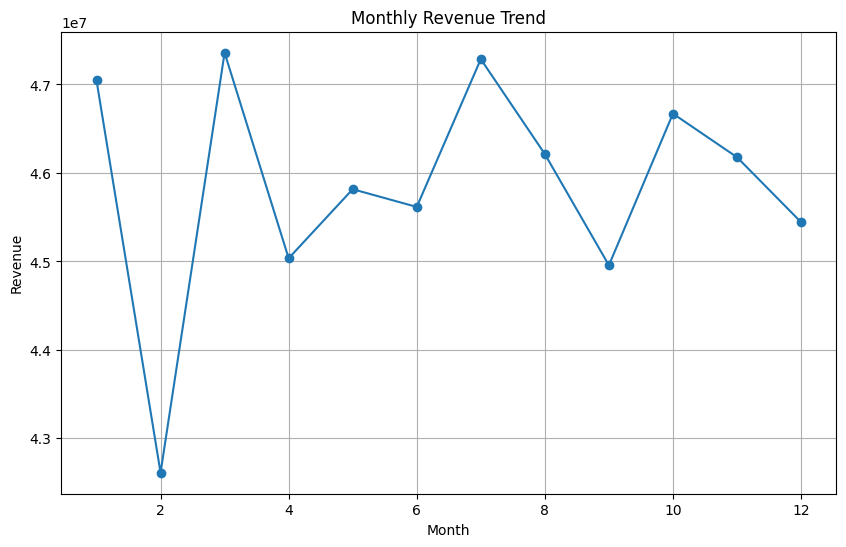

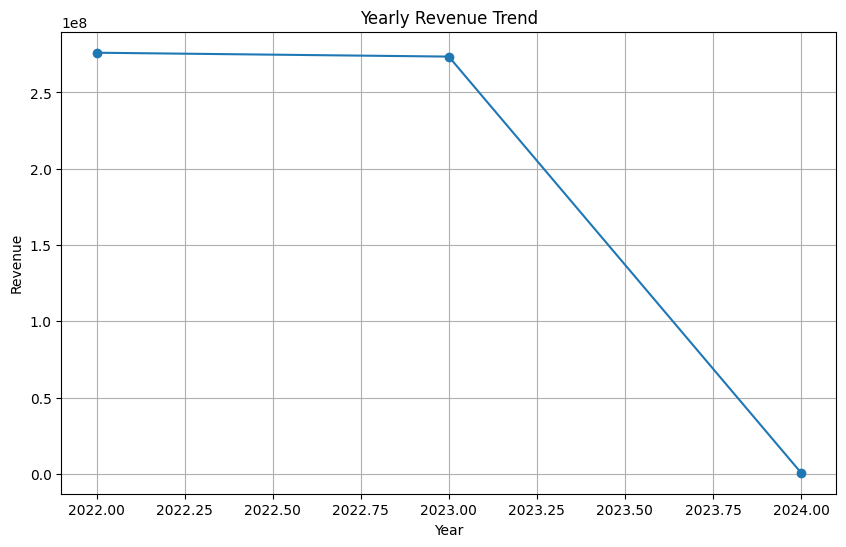

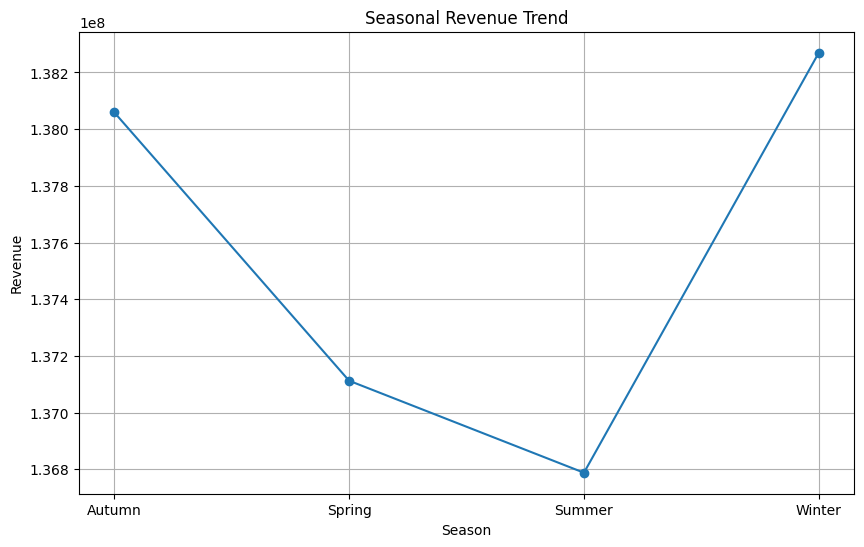

In [17]:
# Loop through each group and plot
for group, data, title, xlabel in groups:
    plt.figure(figsize=(10, 6))
    plt.plot(data[group], data['Revenue'], marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Revenue')
    plt.grid(True)
    plt.show()

> Weekly revenue trend, shows there is an increase Units Sales during summer weeks (23-31) and during last weeks of the year (50-52)!  

> Monthly revenue trend, shows there is an decrease in Units Sold after new year (in Februari) then it increases again in March and also there is an increase Units Sales during summer months (6-8)!  

> Yearly revenue trend, shows linear Units Sold during 2022 and 2023 but decreases in 2024 (It maybe is due to the dataset has only data for the first month of 2024 and not the whole year)!  

> Seasonal revenue trend, starts in Autumn in the highest Units Sales, then decreases during Spring and is lowest in the Summer then increases during Winter.

#### What is the impact of holidays and promotions on sales?

In [18]:
# Group by Holiday/Promotion
sales_holiday_promo = dataset.groupby('Holiday/Promotion')['Units Sold'].mean().reset_index()

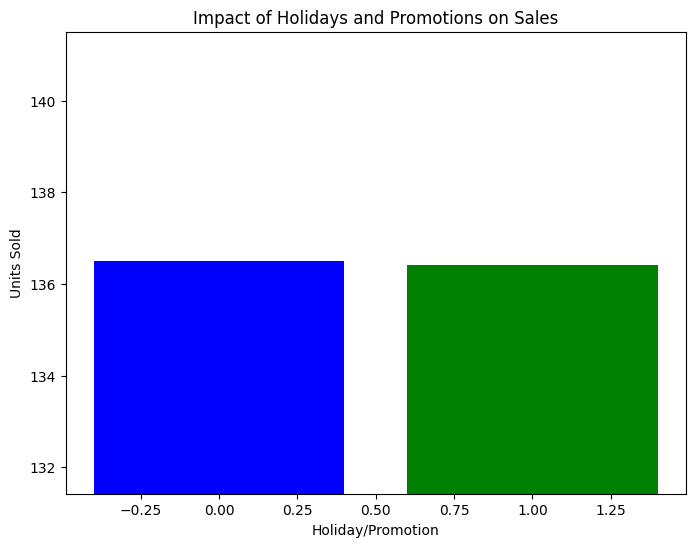

In [19]:
# Plotting sales during holidays and promotions
plt.figure(figsize=(8, 6))
plt.bar(sales_holiday_promo['Holiday/Promotion'], sales_holiday_promo['Units Sold'], color=['blue', 'green'])
#plt.axhline(y=avg_sales, color='r', linestyle='--', label=f'Average Sales: {avg_sales:.2f}')
plt.title('Impact of Holidays and Promotions on Sales')
plt.xlabel('Holiday/Promotion')
plt.ylim(sales_holiday_promo['Units Sold'].min() - 5, sales_holiday_promo['Units Sold'].max() + 5)
plt.ylabel('Units Sold')
plt.show()

In [20]:
# Sales during holidays/promotions
sales_during_promo = dataset[dataset['Holiday/Promotion'] == 1]['Units Sold']

# Sales during non-holidays/promotions
sales_not_promo = dataset[dataset['Holiday/Promotion'] == 0]['Units Sold']

# Perform t-test
t_stat, p_value = stats.ttest_ind(sales_during_promo, sales_not_promo)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.10108694761422296, P-value: 0.9194817165094531


> It seems like holidays and promotions might not have a strong impact on your sales based on the current data. The P-value of 0.919 suggests that the difference in sales between regular days and holiday/promotion days is not statistically significant.

#### How does weather affect sales patterns across different product categories?

In [21]:
# Group by Weather Condition and Category
weather_sales = dataset.groupby(['Weather Condition', 'Category'])['Units Sold'].mean().reset_index()

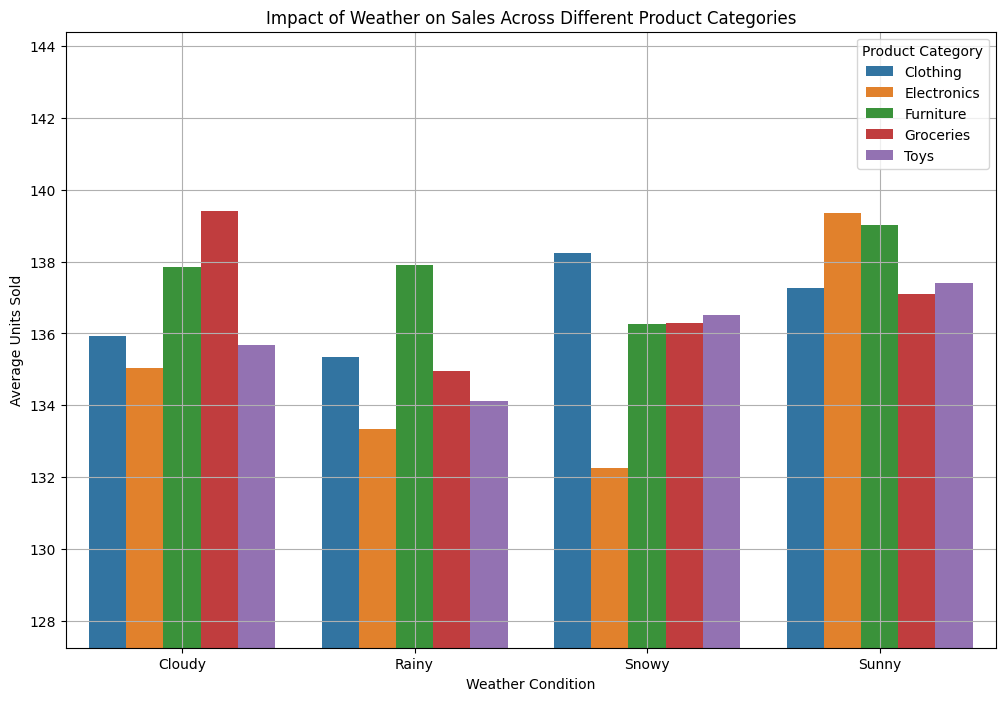

In [22]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(x='Weather Condition', y='Units Sold', hue='Category', data=weather_sales)

# Customize the plot
plt.title('Impact of Weather on Sales Across Different Product Categories')
plt.xlabel('Weather Condition')
plt.ylabel('Average Units Sold')
plt.ylim(weather_sales['Units Sold'].min() - 5, weather_sales['Units Sold'].max() + 5)
plt.legend(title='Product Category')
plt.grid(True)
plt.show()

> Cloudy; Average units sold of Groceries are highest, followed by Furniture and Clothing.  
Rainy; Average Units sold of Furniture is the highest, followed by Clothing and Groceries. However compared to Cloudy weather the average units solds in each category is lower in total!  
Snowy; Average Units sold of Clothing is the highest, followed by Toys, Furniture and Groceries. However compared to Rainy the average units solds in each category except Electronics is higher!  
Sunny; Average Units sold of Electronics together with Furniture are the highest, the other categories are almost at the same level. However compared to Snowy, average units sold is hige in total! 

#### Are there any significant correlations between inventory levels and sales figures?

In [23]:
# Calculate correlation
correlation = dataset['Inventory Level'].corr(dataset['Units Sold'])
print(f"Correlation between Inventory Level and Units Sold: {correlation}")

Correlation between Inventory Level and Units Sold: 0.5899945054936709


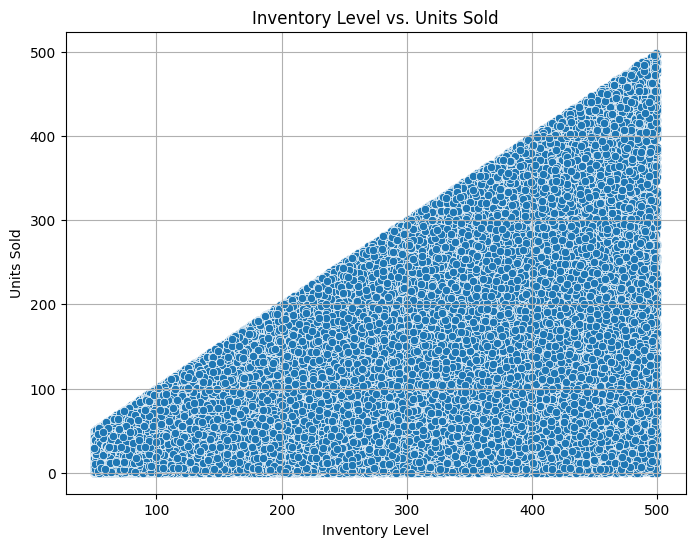

In [24]:
# Scatter plot of Inventory Level vs. Units Sold
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Inventory Level', y='Units Sold', data=dataset)
plt.title('Inventory Level vs. Units Sold')
plt.xlabel('Inventory Level')
plt.ylabel('Units Sold')
plt.grid()
plt.show()

> A positive correlation of 0.59 indicates a moderate to strong relationship between inventory levels and sales figures. This suggests that having higher inventory levels is associated with higher sales, which can be crucial for demand planning and inventory management.

#### How do sales trends differ across various geographic regions?

In [25]:
# Group by Region
regional_sales = dataset.groupby('Region')['Units Sold'].mean().reset_index()

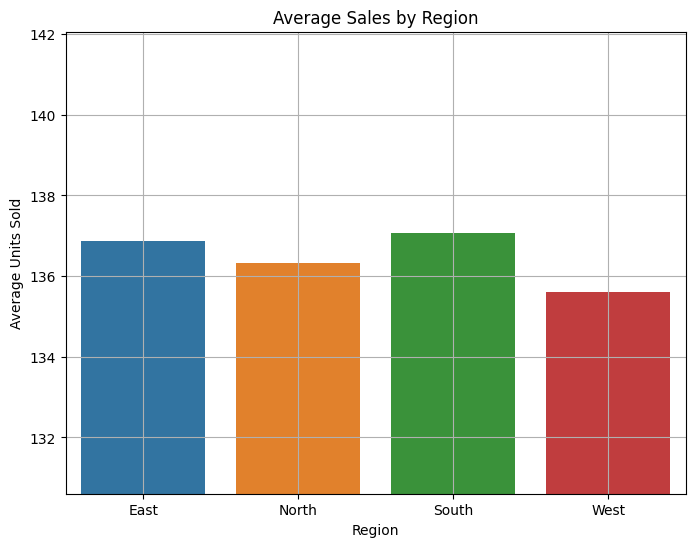

In [26]:
# Bar plot of Units Sold by Region
plt.figure(figsize=(8, 6))
sns.barplot(x='Region', y='Units Sold', data=regional_sales, hue=regional_sales['Region'])
plt.title('Average Sales by Region')
plt.xlabel('Region')
plt.ylabel('Average Units Sold')
plt.ylim(regional_sales['Units Sold'].min() - 5, regional_sales['Units Sold'].max() + 5)
plt.grid()
plt.show()

> Average Units sold in South and Eath are higher than the North and West has the lowest average units sold!

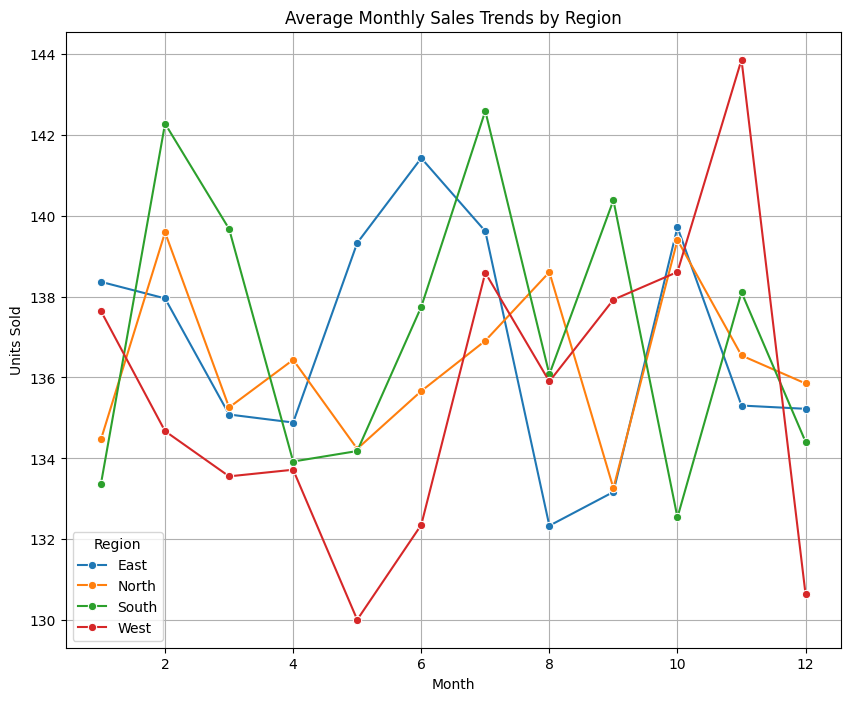

In [27]:
# Group by Region and Month
regional_monthly_sales = dataset.groupby(['Region', 'Month'])['Units Sold'].mean().reset_index()

# Plotting monthly sales trends for each region
plt.figure(figsize=(10, 8))
sns.lineplot(x='Month', y='Units Sold', hue='Region', data=regional_monthly_sales, marker='o')
plt.title('Average Monthly Sales Trends by Region')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

> Average Monthly units sold in West region has the sharpest fluctuations, it goes down during April-May and it increases during October-Novemeber and then decreases in December!  
In other regions the fluctuations are closer to each other compared to West region!

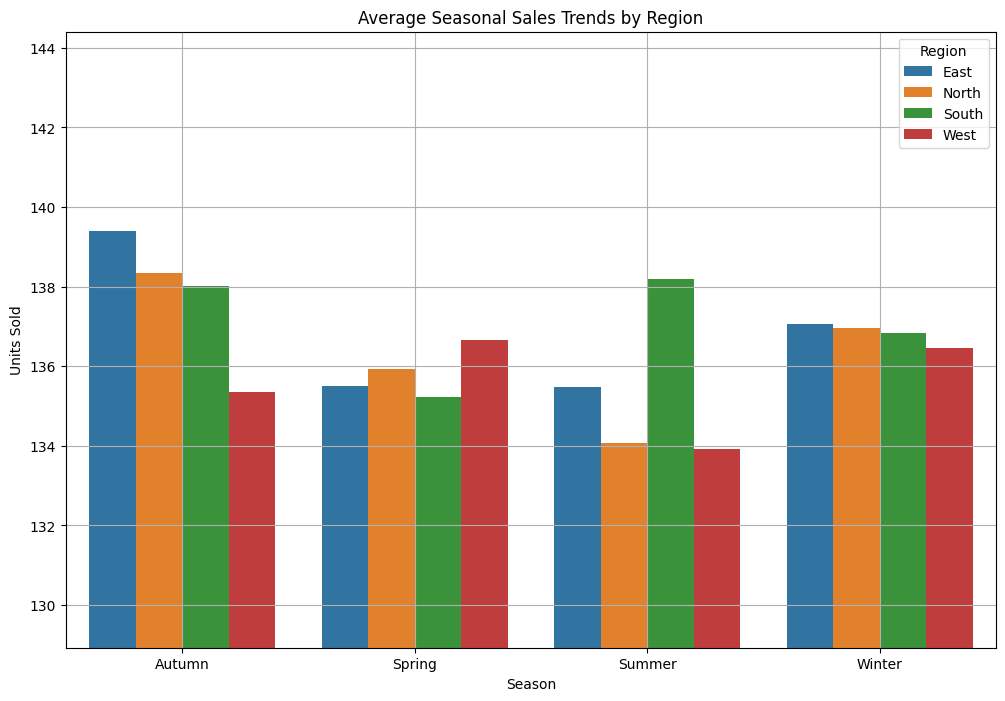

In [28]:
# Group by Region and Season
regional_seasonal_sales = dataset.groupby(['Region', 'Seasonality'])['Units Sold'].mean().reset_index()

# Plotting seasonal sales trends for each region
plt.figure(figsize=(12, 8))
sns.barplot(x='Seasonality', y='Units Sold', hue='Region', data=regional_seasonal_sales)
plt.title('Average Seasonal Sales Trends by Region')
plt.xlabel('Season')
plt.ylabel('Units Sold')
plt.ylim(regional_seasonal_sales['Units Sold'].min() - 5, regional_seasonal_sales['Units Sold'].max() + 5)
plt.grid(True)
plt.show()


> In Autumn; the average units sold in East is the highest followed by North and South, West has the lowest here!  
In Spring; the average units solds in different regions are almost similar, West region has the highest here!  
In Summer; South region clearly has the highest average units sold here, followed by East. North and West have almost identical average units sold!  
In Winter; All regions have almost identical average units sold!

#### The next question is: How do sales trends differ across various product categories?

In [29]:
# Group by Category
category_sales = dataset.groupby('Category')['Units Sold'].mean().reset_index()

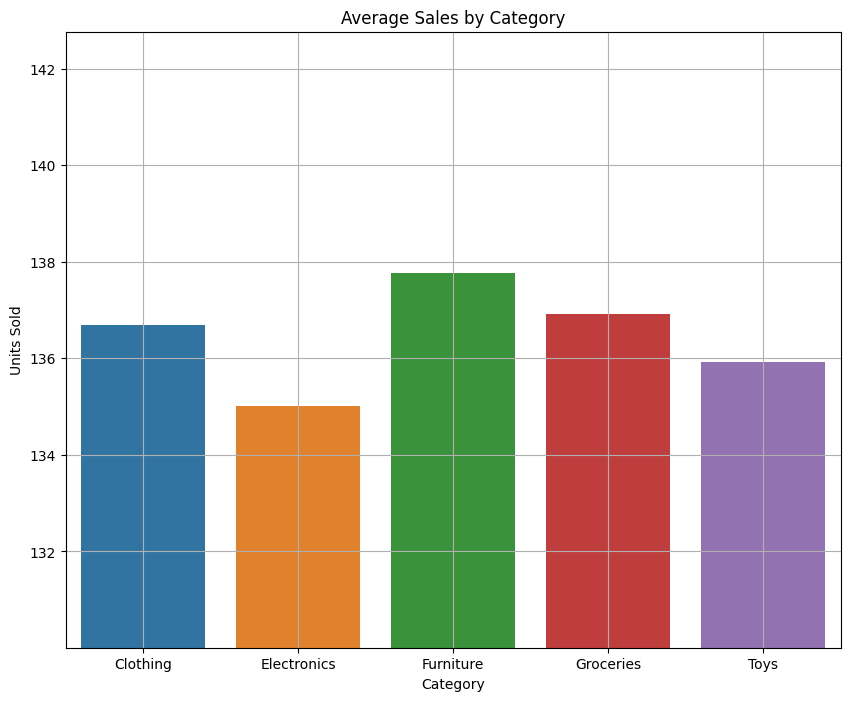

In [30]:
# Bar plot of Units Sold by Category
plt.figure(figsize=(10, 8))
sns.barplot(x='Category', y='Units Sold', data=category_sales, hue=category_sales['Category'])
plt.title('Average Sales by Category')
plt.xlabel('Category')
plt.ylabel('Units Sold')
plt.ylim(category_sales['Units Sold'].min() - 5, category_sales['Units Sold'].max() + 5)
plt.grid(True)
plt.show()

> Average Units sold of Furniture is the highest followed by Groceries and Clothing. The lowest average units sold is Electronics!

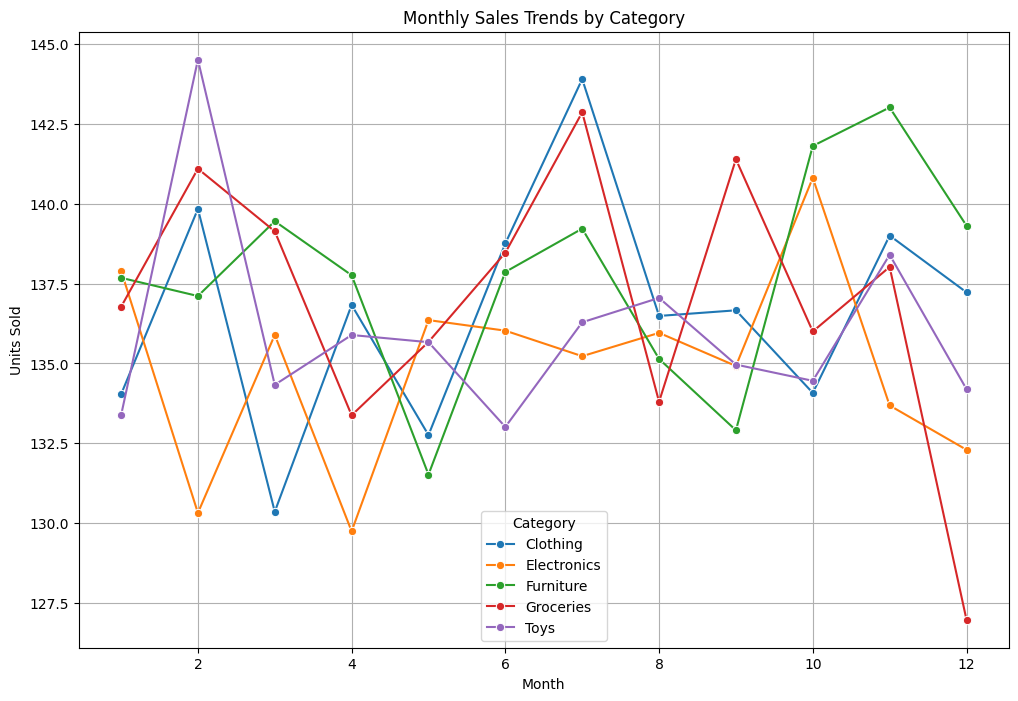

In [31]:
# Group by Category and Month
category_monthly_sales = dataset.groupby(['Category', 'Month'])['Units Sold'].mean().reset_index()

# Plotting monthly sales trends for each category
plt.figure(figsize=(12, 8))
sns.lineplot(x='Month', y='Units Sold', hue='Category', data=category_monthly_sales, marker='o')
plt.title('Monthly Sales Trends by Category')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

> The Toys category increases the most in the first months of year and the grocery category decreases the most during the last month of the year!

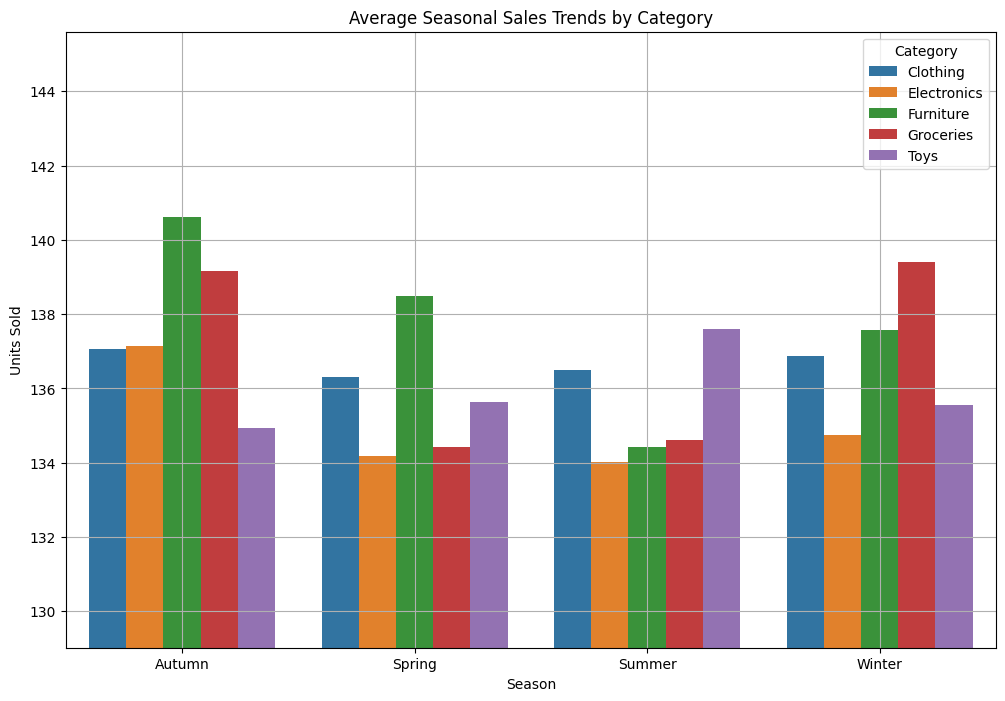

In [32]:
# Group by Category and Season
category_seasonal_sales = dataset.groupby(['Category', 'Seasonality'])['Units Sold'].mean().reset_index()

# Plotting seasonal sales trends for each category
plt.figure(figsize=(12, 8))
sns.barplot(x='Seasonality', y='Units Sold', hue='Category', data=category_seasonal_sales)
plt.title('Average Seasonal Sales Trends by Category')
plt.xlabel('Season')
plt.ylabel('Units Sold')
plt.ylim(category_seasonal_sales['Units Sold'].min() - 5, category_seasonal_sales['Units Sold'].max() + 5)
plt.grid(True)
plt.show()

### Data Preprocessing
#### Auto Correlation analysis

In [33]:
dataset.set_index('Date', inplace=True)
dataset .sort_index(inplace=True)

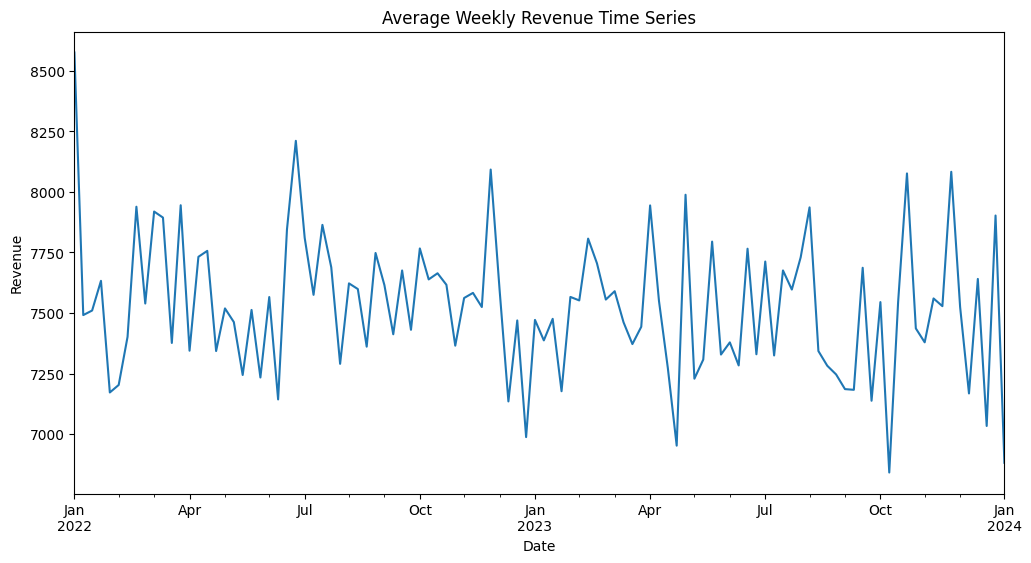

In [131]:
# Resample the 'Revenue' data to weekly frequency and calculate the mean
weekly_revenue = dataset['Revenue'].resample('W').mean()

# Plot the aggregated weekly revenue
weekly_revenue.plot(title='Average Weekly Revenue Time Series', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

<Figure size 1200x600 with 0 Axes>

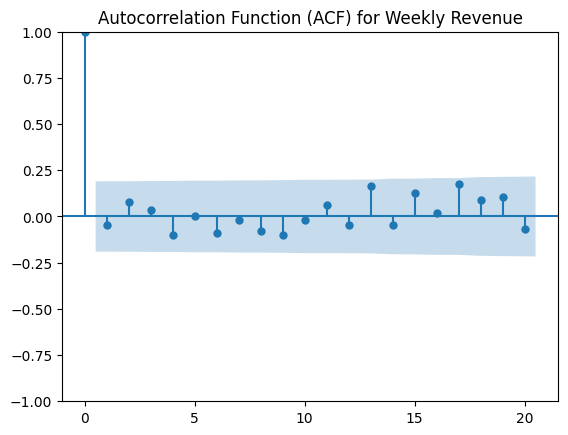

<Figure size 1200x600 with 0 Axes>

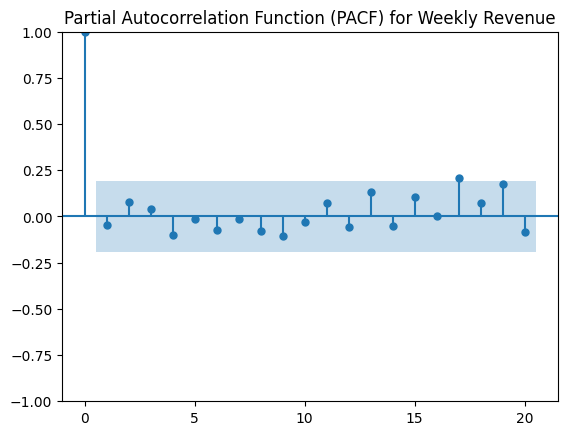

In [132]:
# Plot the ACF for the weekly revenue
plt.figure(figsize=(12, 6))
plot_acf(weekly_revenue.dropna(), lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Weekly Revenue')
plt.show()

# Plot the PACF for the weekly revenue
plt.figure(figsize=(12, 6))
plot_pacf(weekly_revenue.dropna(), lags=20, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) for Weekly Revenue')
plt.show()

#### Checking if the revenue time series is stationary

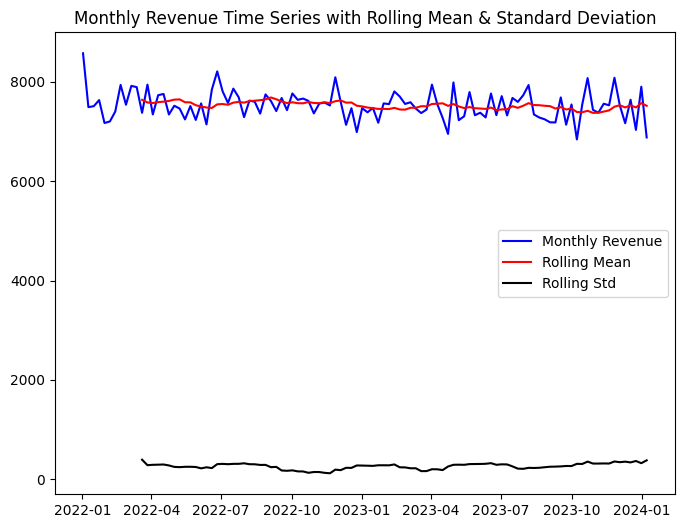

In [116]:
# Resample the data to monthly frequency and calculate the mean revenue for each month
monthly_data = dataset['Revenue'].resample('W').mean()

# Calculate rolling statistics on monthly data
rolling_mean_monthly = monthly_data.rolling(window=12).mean()
rolling_std_monthly = monthly_data.rolling(window=12).std()

# Plot the monthly time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(8, 6))
plt.plot(monthly_data, color='blue', label='Monthly Revenue')
plt.plot(rolling_mean_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_monthly, color='black', label='Rolling Std')
plt.title('Monthly Revenue Time Series with Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show()


In [125]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'Revenue' column
result = adfuller(dataset['Revenue'].resample('W').mean())

# Extract and print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpret the result
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -11.10406447550428
p-value: 3.8015227960401484e-20
Critical Values:
   1%: -3.4942202045135513
   5%: -2.889485291005291
   10%: -2.5816762131519275
The time series is stationary.


#### Seasonal Decomposition

In [38]:
# Resample the data to monthly frequency by summing the revenue for each month
monthly_data = dataset['Revenue'].resample('ME').sum()

In [39]:
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)

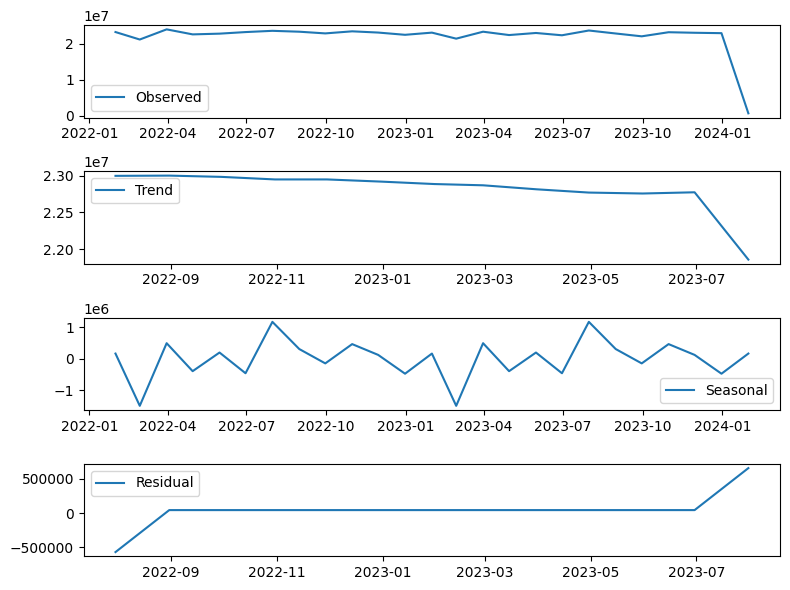

In [40]:
# Plot the decomposed components
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


> Based on the ACF, PACF, and stationarity results, an ARIMA model with parameters (p, d, q) such as ARIMA(1, 0, 1) might be a good starting point. Given the clear seasonality, a SARIMA model with seasonal parameters should also be considered (e.g., SARIMA(1, 0, 1)(P, D, Q, S) where S is 12 for monthly data).  
> The data is stationary, meaning its statistical properties like mean and variance do not change over time. This is a critical condition for using ARIMA models, which assume stationarity. Since no differencing is needed to achieve stationarity, the integration parameter (d) in the ARIMA model can be set to 0.  

#### Model Building

In [128]:
# Resample the 'Revenue' data to weekly frequency and calculate the mean
weekly_revenue = dataset['Revenue'].resample('W').mean()

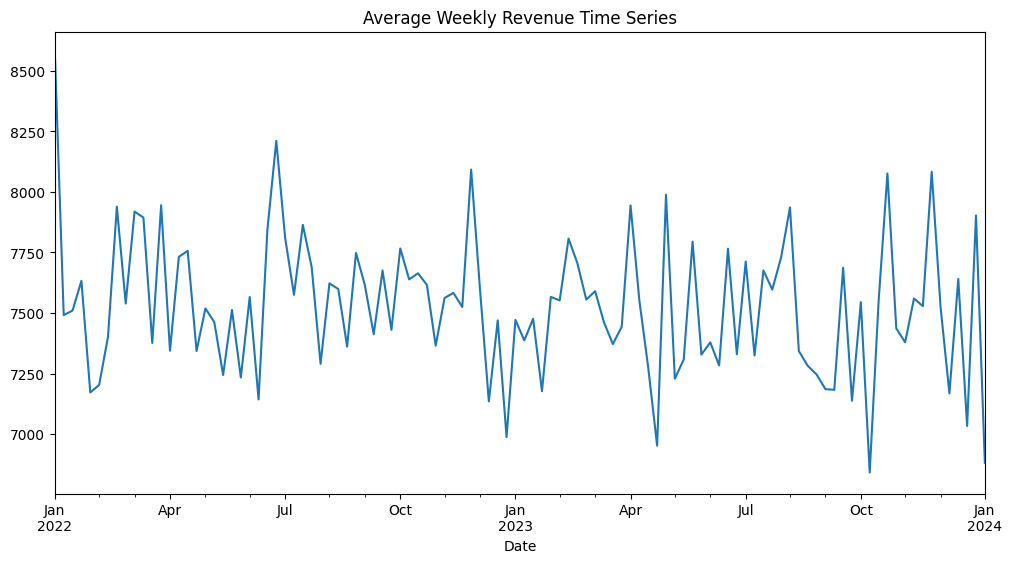

In [129]:
# Plot the aggregated weekly revenue
weekly_revenue.plot(title='Average Weekly Revenue Time Series', figsize=(12, 6))
plt.show()


In [109]:
# Define the split date for the weekly aggregated data
split_date_weekly = '2023-10-31'

# Training set
train_weekly = weekly_revenue[weekly_revenue.index <= split_date_weekly]

# Test set
test_weekly = weekly_revenue[weekly_revenue.index > split_date_weekly]

In [110]:
train_weekly.tail() 

Date
2023-10-01    7544.880043
2023-10-08    6841.095829
2023-10-15    7544.950300
2023-10-22    8076.230643
2023-10-29    7436.212900
Freq: W-SUN, Name: Revenue, dtype: float64

In [111]:
test_weekly.tail()

Date
2023-12-10    7167.632500
2023-12-17    7640.572314
2023-12-24    7033.317943
2023-12-31    7902.414829
2024-01-07    6881.243600
Freq: W-SUN, Name: Revenue, dtype: float64

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model with seasonal components
model_sarima = SARIMAX(train_weekly, order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))  # Adjust parameters as needed
sarima_fit = model_sarima.fit(disp=False)

c:\Users\Farhad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


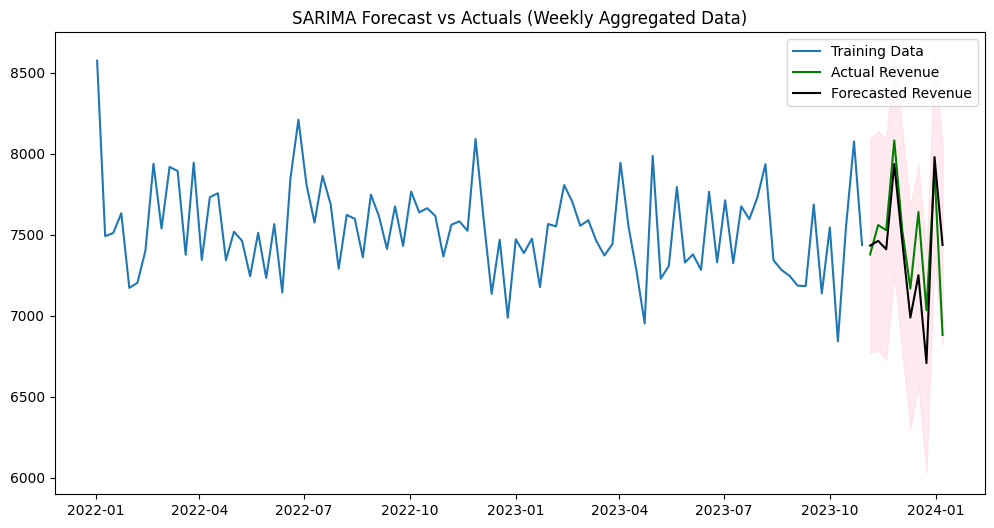

In [115]:
# Forecast
forecast_sarima = sarima_fit.get_forecast(steps=len(test_weekly))
forecasted_mean_sarima = forecast_sarima.predicted_mean
conf_int_sarima = forecast_sarima.conf_int()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_weekly, label='Training Data')
plt.plot(test_weekly, label='Actual Revenue', color='green')
plt.plot(forecasted_mean_sarima, label='Forecasted Revenue', color='black')
plt.fill_between(conf_int_sarima.index, conf_int_sarima.iloc[:, 0], conf_int_sarima.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast vs Actuals (Weekly Aggregated Data)')
plt.show()

In [91]:
# Define and fit the ARIMA model on the weekly data
model_weekly = ARIMA(train_weekly, order=(1, 0, 1))  # Adjust (p, d, q) as needed
arima_fit_weekly = model_weekly.fit()

In [92]:
# Print the summary of the fitted model
print(arima_fit_weekly.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  100
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -706.460
Date:                Wed, 08 Jan 2025   AIC                           1418.920
Time:                        20:56:12   BIC                           1426.675
Sample:                    01-02-2022   HQIC                          1422.056
                         - 11-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4432      0.063     -7.039      0.000      -0.567      -0.320
ma.L1         -0.9999      0.122     -8.189      0.000      -1.239      -0.761
sigma2      9.755e+04   1.25e-06   7.79e+10      0.0

In [93]:
# Forecast for the length of the test set
forecast_weekly = arima_fit_weekly.get_forecast(steps=len(test_weekly))

# Get the predicted mean values
forecasted_mean_weekly = forecast_weekly.predicted_mean

# Get confidence intervals
conf_int_weekly = forecast_weekly.conf_int()

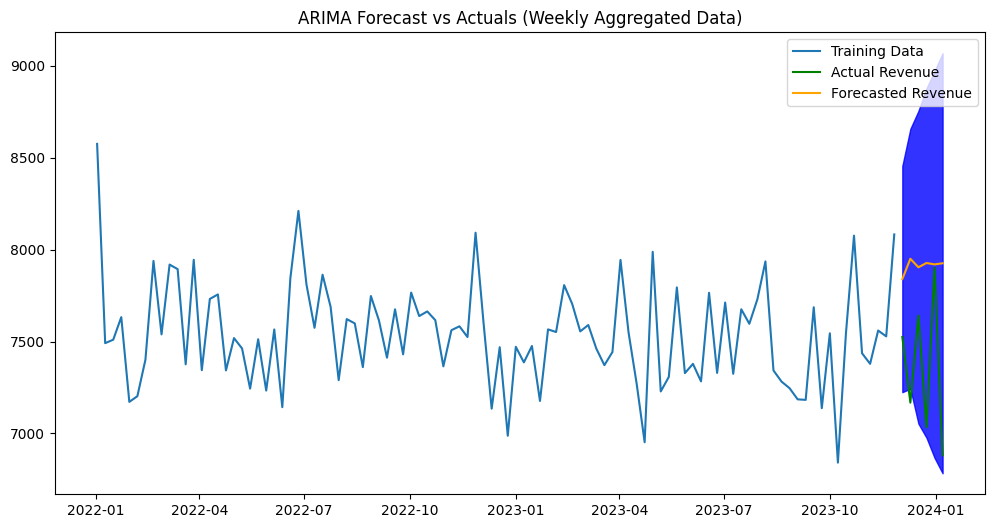

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_weekly, label='Training Data')
plt.plot(test_weekly, label='Actual Revenue', color='green')
plt.plot(forecasted_mean_weekly, label='Forecasted Revenue', color='orange')
plt.fill_between(conf_int_weekly.index, conf_int_weekly.iloc[:, 0], conf_int_weekly.iloc[:, 1], color='blue', alpha=0.8)
plt.legend()
plt.title('ARIMA Forecast vs Actuals (Weekly Aggregated Data)')
plt.show()